### Multi Classification using MLP (MNIST)

In [16]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [5]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

if device == "cuda":
  _ = torch.cuda.manual_seed_all(777)

else:
  _ = torch.manual_seed(1)

In [10]:
from torchvision import datasets
from torchvision.transforms import transforms

In [11]:
# Download MNIST Dataset
mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 271646126.09it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 13834592.72it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 146650509.90it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6993586.19it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



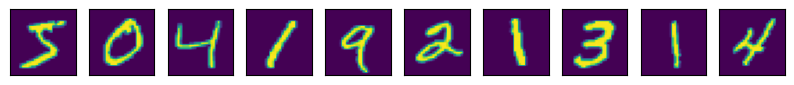

In [13]:
# See the sample raw data
import matplotlib.pyplot as plt

sample_mnist = mnist_train.data[0:10].numpy()

fig, ax = plt.subplots(1, len(sample_mnist), figsize=(10, 1))
for idx, sample in enumerate(sample_mnist):
  ax[idx].imshow(sample_mnist[idx])
  ax[idx].get_xaxis().set_visible(False)
  ax[idx].get_yaxis().set_visible(False)

In [34]:
# Put it in DataLoader
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import TensorDataset

dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True, drop_last=True) # Normalized itself

In [38]:
# Define model class
class MnistMultiClassifierMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(28 * 28, 256)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(256, 128)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.relu2(x)
    return self.linear3(x)

model = (MnistMultiClassifierMLP()).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss().to(device)
total_epochs = 15

# Let's train
for epoch in range(total_epochs + 1):

  avg_cost = 0
  total_batch = len(dataloader)

  for batch_idx, sample in enumerate(dataloader):

    x_batch, y_batch = sample
    x_batch, y_batch = x_batch.view(-1, 28 * 28).to(device), y_batch.to(device)

    y_pred = model(x_batch)

    cost = criterion(y_pred, y_batch)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  print (f"Epoch {epoch:4d}/{total_epochs} Cost: {avg_cost.item():.6f}")


Epoch    0/15 Cost: 0.664375
Epoch    1/15 Cost: 0.267382
Epoch    2/15 Cost: 0.194348
Epoch    3/15 Cost: 0.151413
Epoch    4/15 Cost: 0.123927
Epoch    5/15 Cost: 0.103533
Epoch    6/15 Cost: 0.088841
Epoch    7/15 Cost: 0.076431
Epoch    8/15 Cost: 0.065997
Epoch    9/15 Cost: 0.059153
Epoch   10/15 Cost: 0.051463
Epoch   11/15 Cost: 0.045325
Epoch   12/15 Cost: 0.040540
Epoch   13/15 Cost: 0.035988
Epoch   14/15 Cost: 0.031744


Accuracy : 97.87% 




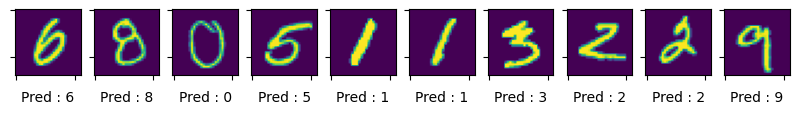

In [39]:

# Let's predict
test_dataloader = DataLoader(mnist_test, batch_size=128, shuffle=True, drop_last=True)

with torch.no_grad():

  total_sample, accuracy = 0, 0

  for test_idx, sample in enumerate(test_dataloader):

    x_test, y_test = sample
    x_test, y_test = (x_test.view(-1, 28 * 28)).to(device), y_test.to(device)

    y_pred = model(x_test).argmax(dim=1)

    total_sample += len(y_test)
    accuracy += (y_pred == y_test).count_nonzero()


    if test_idx == 0:
      fig, ax = plt.subplots(1, 10, figsize=(10, 1))
      for img_idx, x in enumerate(x_test[:10]):

        ax[img_idx].imshow(x.view(28, 28).cpu().numpy())
        ax[img_idx].set_xticklabels([])
        ax[img_idx].set_yticklabels([])
        ax[img_idx].set_xlabel(f"Pred : {y_pred[img_idx]}")

  print(f"Accuracy : {(accuracy / total_sample) * 100:.2f}% \n\n")

